In [1]:
#Optimization packages
using JuMP, Gurobi
# const GRB_ENV = Gurobi.Env(output_flag=1); #supress Gurobi from echo everytime a model is called. 

#Data importation and storage packages
using CSV, DataFrames

#Data processing packages
using LinearAlgebra: norm

#Visualization packages
using Makie, CairoMakie
Makie.inline!(true); #make sure plots are shown in Jupyter notebook.

### 0. Data importation

In [2]:
dataA = CSV.File("HW5_data//dataA.csv") |> Tables.matrix;
dataB = CSV.File("HW5_data//dataB.csv") |> Tables.matrix;

@show nA = size(dataA);
@show nB = size(dataB);

nA = size(dataA) = (1200, 3)
nB = size(dataB) = (1200, 3)


#### functions for x-y grid generation

In [3]:
function getGrid(xs::Vector{Float64}, ys::Vector{Float64})
    lx, ly = length(xs), length(ys)
    lxly = lx*ly
    # res = Array{Base.promote_eltype(xs, ys), 2}(undef, lxly, 2)
    output = zeros(lxly,2);
    ind = 1
    while ind<=lxly
        @inbounds for x in xs
            output[ind] = x
            ind += 1
        end
    end
    for y in ys
        @inbounds for i=1:lx
        output[ind] = y
        ind += 1
        end
    end
    return output
end

#for performance purposes, can be ignored.
function getGrid2(xs::Vector{Float64}, ys::Vector{Float64})
    lx, ly = length(xs), length(ys)
    lxly = lx * ly
    output = zeros(lxly, 2)  # Initialize a matrix to hold pairs of (x, y)
    ind = 1
    for x in xs
        for y in ys
            output[ind, 1] = x  # Store x value
            output[ind, 2] = y  # Store y value
            ind += 1
        end
    end
    return output
end

getGrid2 (generic function with 1 method)

In [4]:
#ranges of the betas.
β1 = collect(-25:0.1:75);
β2 = collect(-40:0.1:40); 
β = getGrid(β1, β2);
println(size(β));

yA  = dataA[:,3];
xA1 = dataA[:,1];
xA2 = dataA[:,2];
yB  = dataB[:,3];
xB1 = dataB[:,1];
xB2 = dataB[:,2];

function calculate_loss(β; 
    yA = yA, yB = yB, 
    xA1 = xA1, xA2 = xA2, 
    xB1 = xB1, xB2 = xB2)
    
    loss_A = (yA .- β[1] * xA1 - β[2] * xA2) .^ 2;
    loss_B = (yB .- β[1] * xB1 - β[2] * xB2) .^ 2;
    loss_All = sum(min.(loss_A, loss_B));
    return loss_All
end

lossAll = zeros(size(β,1),1);
for i = 1:size(β,1)
    lossAll[i] = calculate_loss(β[i,:])
end
lossAll = lossAll/(2*nA[1])

(801801, 2)


801801×1 Matrix{Float64}:
 18069.80893323299
 17991.546993854292
 17913.477915070933
 17835.556884376936
 17757.806088373527
 17680.230400705816
 17602.75802607698
 17525.375732521483
 17448.080466104882
 17370.979265473252
 17294.072130626577
 17217.359061564865
 17140.840058288115
     ⋮
 40172.2801545302
 40319.27448318001
 40465.99608210652
 40613.028730989485
 40760.38485215136
 40908.06389486945
 41055.86516455766
 41204.00752432997
 41352.49097418643
 41501.23519098077
 41650.13555333141
 41799.34842497395

# Part A: Problem Visualization

In [5]:
#Verifying the sizes
@show size(β[:,1])
@show size(β[:,2])
@show size(lossAll)
@show maximum(lossAll)
@show minimum(lossAll)

size(β[:, 1]) = (801801,)
size(β[:, 2]) = (801801,)
size(lossAll) = (801801, 1)
maximum(lossAll) = 41799.34842497395
minimum(lossAll) = 5.421416459079418


5.421416459079418

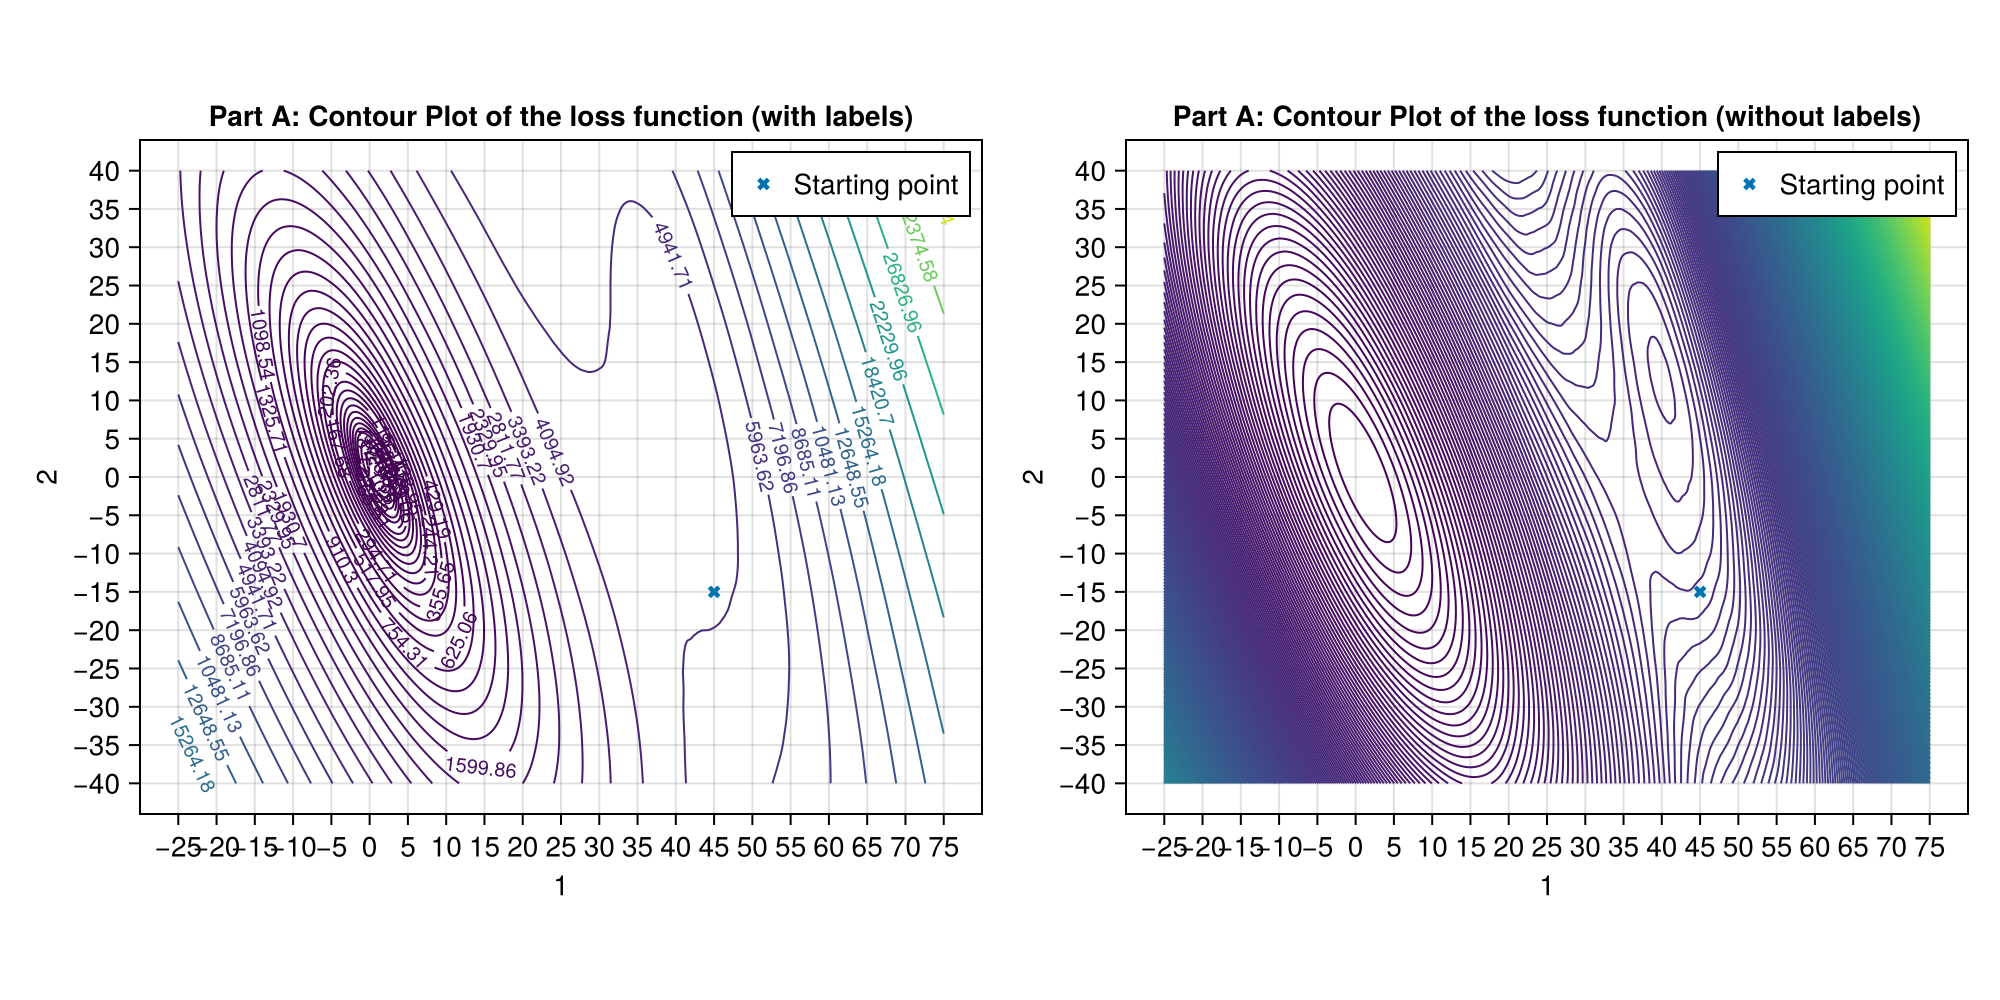

In [6]:
f_data = Figure(size = (1000,500)); 
ax_with_labels = Axis(f_data[1,1], title = "Part A: Contour Plot of the loss function (with labels)", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)
ax_without_labels = Axis(f_data[1,2], title = "Part A: Contour Plot of the loss function (without labels)", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)
c_with_labels = contour!(ax_with_labels,β[:,1], β[:,2], lossAll[:,1], levels = 10.0.^range(1, 5; length=50), labels = true)
s_with_labels = scatter!(ax_with_labels, 45, -15, label = "Starting point", marker = :x)
axislegend(ax_with_labels)

c_wihtout_labels = contour!(ax_without_labels,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e2:4e5, labels = false)
s_wihtout_labels = scatter!(ax_without_labels, 45, -15, label = "Starting point", marker = :x)
axislegend(ax_without_labels)

display(f_data);

From the plot, we can see that the shape is non-convex as there are 2 local minima. This means, for an unconstrained optimization, the result might be sub-optimal, especially with the given starting point, we can see the potential of it descent into the local minima.

# Part B: Gradient descent method

In [7]:
β_container = Vector{Vector{Float64}}();
push!(β_container, [1,2])
push!(β_container, [3,4])

2-element Vector{Vector{Float64}}:
 [1.0, 2.0]
 [3.0, 4.0]

In [8]:
#the learning rate
α = 0.01;
β0 = [45, -15];
βk = β0 ; #initializing
β_container_001 = Vector{Vector{Float64}}();
change = 1;
loss_old = 1;
while change > 1e-4
    #keep track of β
    push!(β_container_001, βk)
    
    loss_set_A = (yA .- βk[1]*xA1 .- βk[2]*xA2) .^ 2;
    loss_set_B = (yB .- βk[1]*xB1 .- βk[2]*xB2) .^ 2;
    is_set_A_min = loss_set_A .< loss_set_B;
    
    #gradient
    grad_set_A = 2 * (yA .- βk[1] * xA1 - βk[2] * xA2) .* hcat(-xA1, -xA2);
    grad_set_B = 2 * (yB .- βk[1] * xB1 - βk[2] * xB2) .* hcat(-xB1, -xB2);

    dk = -sum( ( is_set_A_min' * grad_set_A .+ .!is_set_A_min' * grad_set_B), dims = 1 )/(2*nA[1]);
    βk = βk + α*vec(dk)

    #calculate the new loss
    loss_new = calculate_loss(βk)
    change = abs(loss_new - loss_old)/loss_old
    loss_old = loss_new
end   

In [9]:
#the learning rate
α = 0.1;
β0 = [45, -15];
βk = β0 ; #initializing
β_container_01 = Vector{Vector{Float64}}();
change = 1;
loss_old = 1;
count = 0;
max_iteration = 10000
while change > 1e-4 && count < max_iteration
    count = count + 1
    #keep track of β
    push!(β_container_01, βk)

    #check condition to use gradient from A or B terms.
    loss_set_A = (yA .- βk[1]*xA1 .- βk[2]*xA2) .^ 2;
    loss_set_B = (yB .- βk[1]*xB1 .- βk[2]*xB2) .^ 2;
    is_set_A_min = loss_set_A .< loss_set_B;
    
    #gradient
    grad_set_A = 2 * (yA .- βk[1] * xA1 - βk[2] * xA2) .* hcat(-xA1, -xA2);
    grad_set_B = 2 * (yB .- βk[1] * xB1 - βk[2] * xB2) .* hcat(-xB1, -xB2);

    dk = -sum( ( is_set_A_min' * grad_set_A .+ .!is_set_A_min' * grad_set_B), dims = 1 )/(2*nA[1]);
    βk = βk + α*vec(dk)

    #calculate the new loss
    loss_new = calculate_loss(βk)
    change = abs(loss_new - loss_old)/loss_old
    loss_old = loss_new
end   

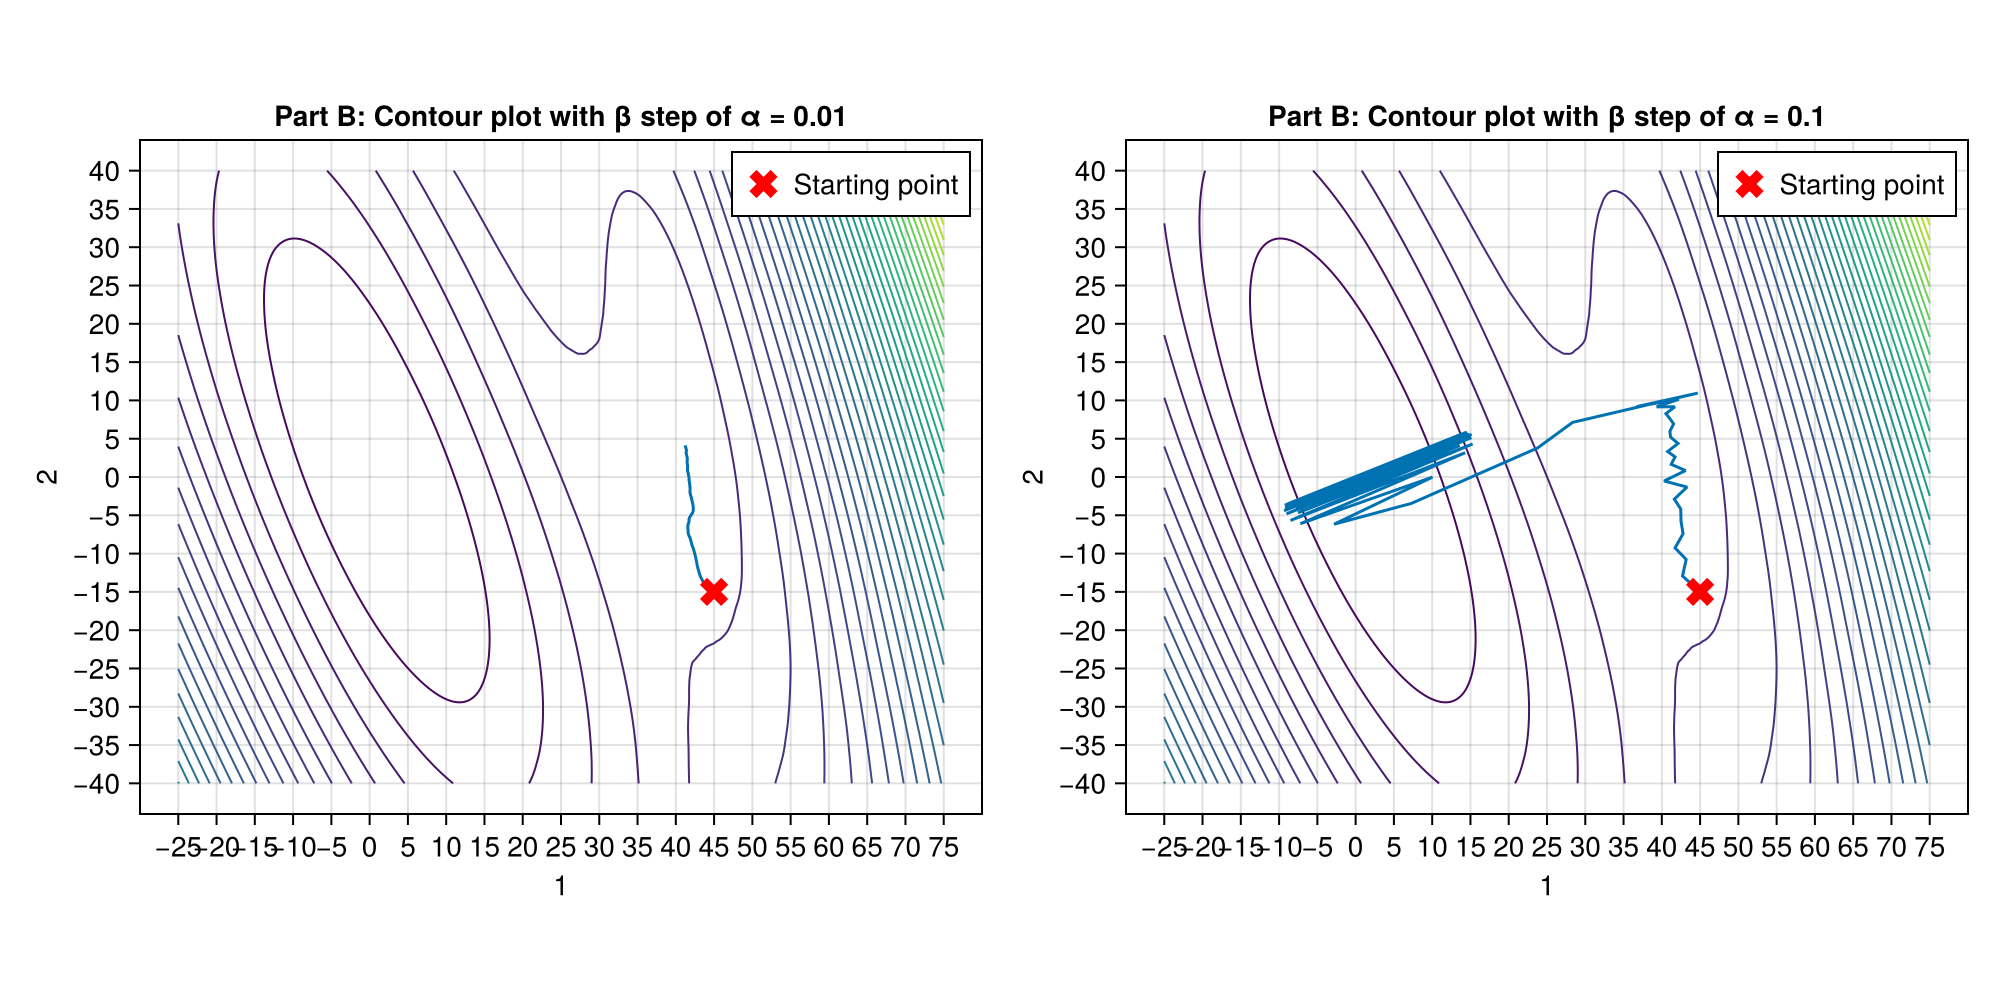

In [10]:
f_result_B = Figure(size = (1000,500)); 

ax_α_001 = Axis(f_result_B[1,1], title = "Part B: Contour plot with β step of α = 0.01", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)

ax_α_01 = Axis(f_result_B[1,2], title = "Part B: Contour plot with β step of α = 0.1", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)

contour_001 = contour!(ax_α_001,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e3:4e5, labels = false)
lines_steps_001 = lines!(ax_α_001, Point2f.(β_container_001))
scatter_start_001 = scatter!(ax_α_001, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
axislegend(ax_α_001)

contour_01 = contour!(ax_α_01,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e3:4e5, labels = false)
lines_steps_01 = lines!(ax_α_01, Point2f.(β_container_01))
scatter_start_01 = scatter!(ax_α_01, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
axislegend(ax_α_01)

display(f_result_B);

For the step size = 0.001, we can see that the value descent to the local minimum as we expected. It take X iterations to reach there, which is a lot compared to the larger step size. This is reasonable as we take a tiny step.As for the larger step size, we can see that it can escape the local minima, however, the size was too big for it to descent into the global minima, resulting in a bouncing back and forth betwen the global minimum.

## Part C: Stochastic Gradient Descent Method

In [12]:
#Using StatsBase to randomly sample the indices
using StatsBase: sample

In [27]:
#the learning rate
α = 0.01;
batch_size = 10
β0 = [45, -15];
βk = β0 ; #initializing
β_container_001 = Vector{Vector{Float64}}();
change = 1;
loss_old = 1;
count = 0;
max_iteration = 10000
while change > 1e-6 && count < max_iteration
    count = count + 1
    #keep track of β
    push!(β_container_001, βk)

    #select `batch_size` indices
    random_idx = sample(1:1200, batch_size; replace=false)
    
    #check condition to use gradient from A or B terms.
    loss_set_A = (yA[random_idx] .- βk[1]*xA1[random_idx] .- βk[2]*xA2[random_idx]) .^ 2;
    loss_set_B = (yB[random_idx] .- βk[1]*xB1[random_idx] .- βk[2]*xB2[random_idx]) .^ 2;
    is_set_A_min = loss_set_A .< loss_set_B;
    
    #gradient
    grad_set_A = 2 * (yA[random_idx] .- βk[1] * xA1[random_idx] - βk[2] * xA2[random_idx]) .* hcat(-xA1[random_idx], -xA2[random_idx]);
    grad_set_B = 2 * (yB[random_idx] .- βk[1] * xB1[random_idx] - βk[2] * xB2[random_idx]) .* hcat(-xB1[random_idx], -xB2[random_idx]);

    dk = -sum( ( is_set_A_min' * grad_set_A .+ .!is_set_A_min' * grad_set_B), dims = 1 )/(2*batch_size);
    βk = βk + α*vec(dk)

    #calculate the new loss
    loss_new = calculate_loss(βk)
    @show change = abs(loss_new - loss_old)/loss_old
    loss_old = loss_new
end   

change = abs(loss_new - loss_old) / loss_old = 1.1548155719808362e7
change = abs(loss_new - loss_old) / loss_old = 0.0006824214071211074
change = abs(loss_new - loss_old) / loss_old = 0.005086862447125779
change = abs(loss_new - loss_old) / loss_old = 0.0034444193878178696
change = abs(loss_new - loss_old) / loss_old = 0.0008771769075935689
change = abs(loss_new - loss_old) / loss_old = 0.008026350717810467
change = abs(loss_new - loss_old) / loss_old = 0.02385540157623866
change = abs(loss_new - loss_old) / loss_old = 0.021736492402588386
change = abs(loss_new - loss_old) / loss_old = 0.04468598219127263
change = abs(loss_new - loss_old) / loss_old = 0.020402901694408084
change = abs(loss_new - loss_old) / loss_old = 0.006757664693337369
change = abs(loss_new - loss_old) / loss_old = 0.003997570631891901
change = abs(loss_new - loss_old) / loss_old = 0.00622219447115744
change = abs(loss_new - loss_old) / loss_old = 0.0015405293100551104
change = abs(loss_new - loss_old) / loss_old = 

In [ ]:
β_container_001

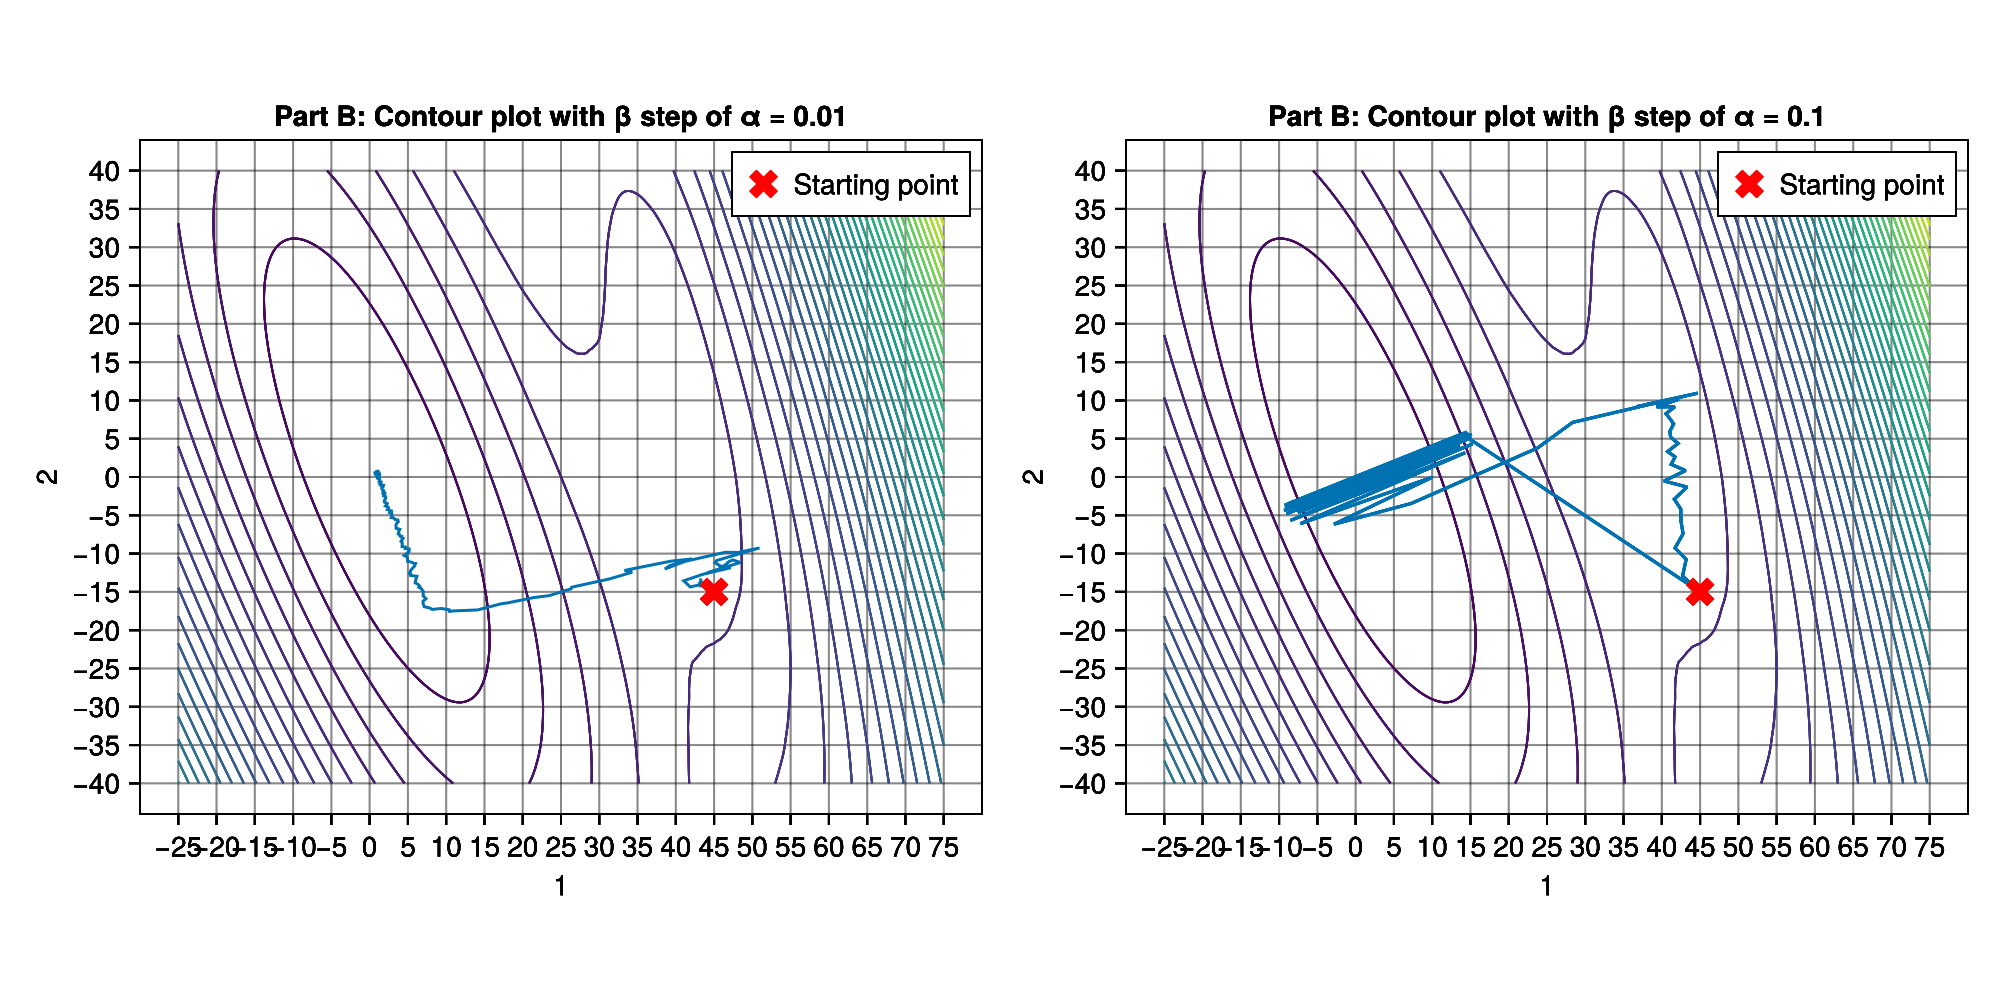

In [28]:
f_result_C = Figure(size = (1000,500)); 

ax_α_001 = Axis(f_result_B[1,1], title = "Part B: Contour plot with β step of α = 0.01", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)

ax_α_01 = Axis(f_result_B[1,2], title = "Part B: Contour plot with β step of α = 0.1", xlabel = "1" , ylabel = "2", aspect = DataAspect(),
yticks = -40:5:40, xticks = -25:5:75)

contour_001 = contour!(ax_α_001,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e3:4e5, labels = false)
lines_steps_001 = lines!(ax_α_001, Point2f.(β_container_001))
scatter_start_001 = scatter!(ax_α_001, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
axislegend(ax_α_001)

contour_01 = contour!(ax_α_01,β[:,1], β[:,2], lossAll[:,1], levels = 0:1e3:4e5, labels = false)
lines_steps_01 = lines!(ax_α_01, Point2f.(β_container_01))
scatter_start_01 = scatter!(ax_α_01, 45, -15, label = "Starting point", marker = :x, markersize = 20, color = :red)
axislegend(ax_α_01)

display(f_result_B);

4-element Vector{Vector{Float64}}:
 [45.0, -15.0]
 [45.00096252028902, -14.995659448021195]
 [44.93980436704557, -14.998591144425218]
 [44.99498668998208, -14.969916712919341]